In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sealsml.data import Preprocessor
import pandas as pd

In [4]:
ls /glade/derecho/scratch/dgagne/SEALS_output/train_20231206

model_2023-12-06_1600.keras      scaler_2023-12-06_1600.json
model_hist_2023-12-06_1600.nc    train_files.csv
model_output_2023-12-06_1600.nc  validation_files.csv


In [3]:
d = pd.read_csv("/glade/derecho/scratch/dgagne/SEALS_output/train_20231206/validation_files.csv")

In [6]:
d['validation_files'].values

array(['/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_NBL2m_Ug2p5_src10kg_a.6.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_NBL2m_Ug10_src1-8kg_b.2.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug3p6_src10kg_b.1.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_DC_Ug15_src_9_10kg_hour_01.6.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_FE_NBL2m_Ug10_src1-8kg_a.3.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug5_src1-8kg_a.6.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug10_src10kg_a.4.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug5_src10kg_a.2.nc',
       '/glade/derecho/scratch/dgagne/SEALS_training_data_20231206/training_data_CBL2m_Ug3p6_src1-8kg_b.4.nc',
     

In [7]:
pre = Preprocessor()
val_encoder, val_decoder, targets = pre.load_data(d["validation_files"].values)

In [15]:
hist = pd.read_csv("/glade/derecho/scratch/dgagne/SEALS_output/train_20231206/model_hist_2023-12-06_1600.nc")

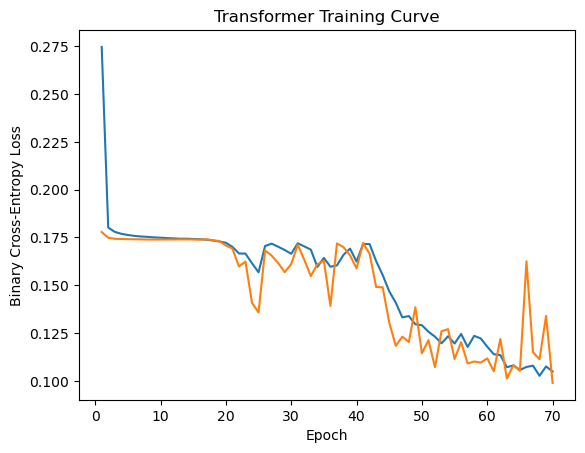

In [142]:
plt.plot(np.arange(1, 71), hist["loss"])
plt.plot(np.arange(1, 71), hist["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Transformer Training Curve")
plt.savefig("training_curve.png", dpi=300, bbox_inches="tight")

In [20]:
pred_ds = xr.open_dataset("/glade/derecho/scratch/dgagne/SEALS_output/train_20231206/model_output_2023-12-06_1600.nc")

In [22]:
pred_ds["probabilities"]

<xarray.DataArray 'probabilities' (sample: 15000, pot_leak_locs: 20)>
[300000 values with dtype=float32]
Dimensions without coordinates: sample, pot_leak_locs

In [34]:
val_decoder[0, :, 0, 0, 0].values

array([ 2.62078784e+03,  2.59449487e+03,  2.61419312e+03,  2.58614111e+03,
        2.61663208e+03,  2.57159644e+03,  2.59753369e+03,  2.60049072e+03,
        2.61199438e+03,  2.60619775e+03,  2.58849927e+03,  2.57934375e+03,
        2.61833130e+03,  2.57734595e+03,  2.61392993e+03,  2.59315039e+03,
        2.57982275e+03,  2.59187842e+03,  2.61912549e+03, -1.00000000e+00])

(15000, 20, 1, 8, 2)

In [36]:
val_decoder["variable"]

<xarray.DataArray 'variable' (variable: 8)>
array(['ref_distance', 'ref_azi_sin', 'ref_azi_cos', 'ref_elv', 'u', 'v', 'w',
       'q_CH4'], dtype='<U12')
Coordinates:
  * variable  (variable) <U12 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'

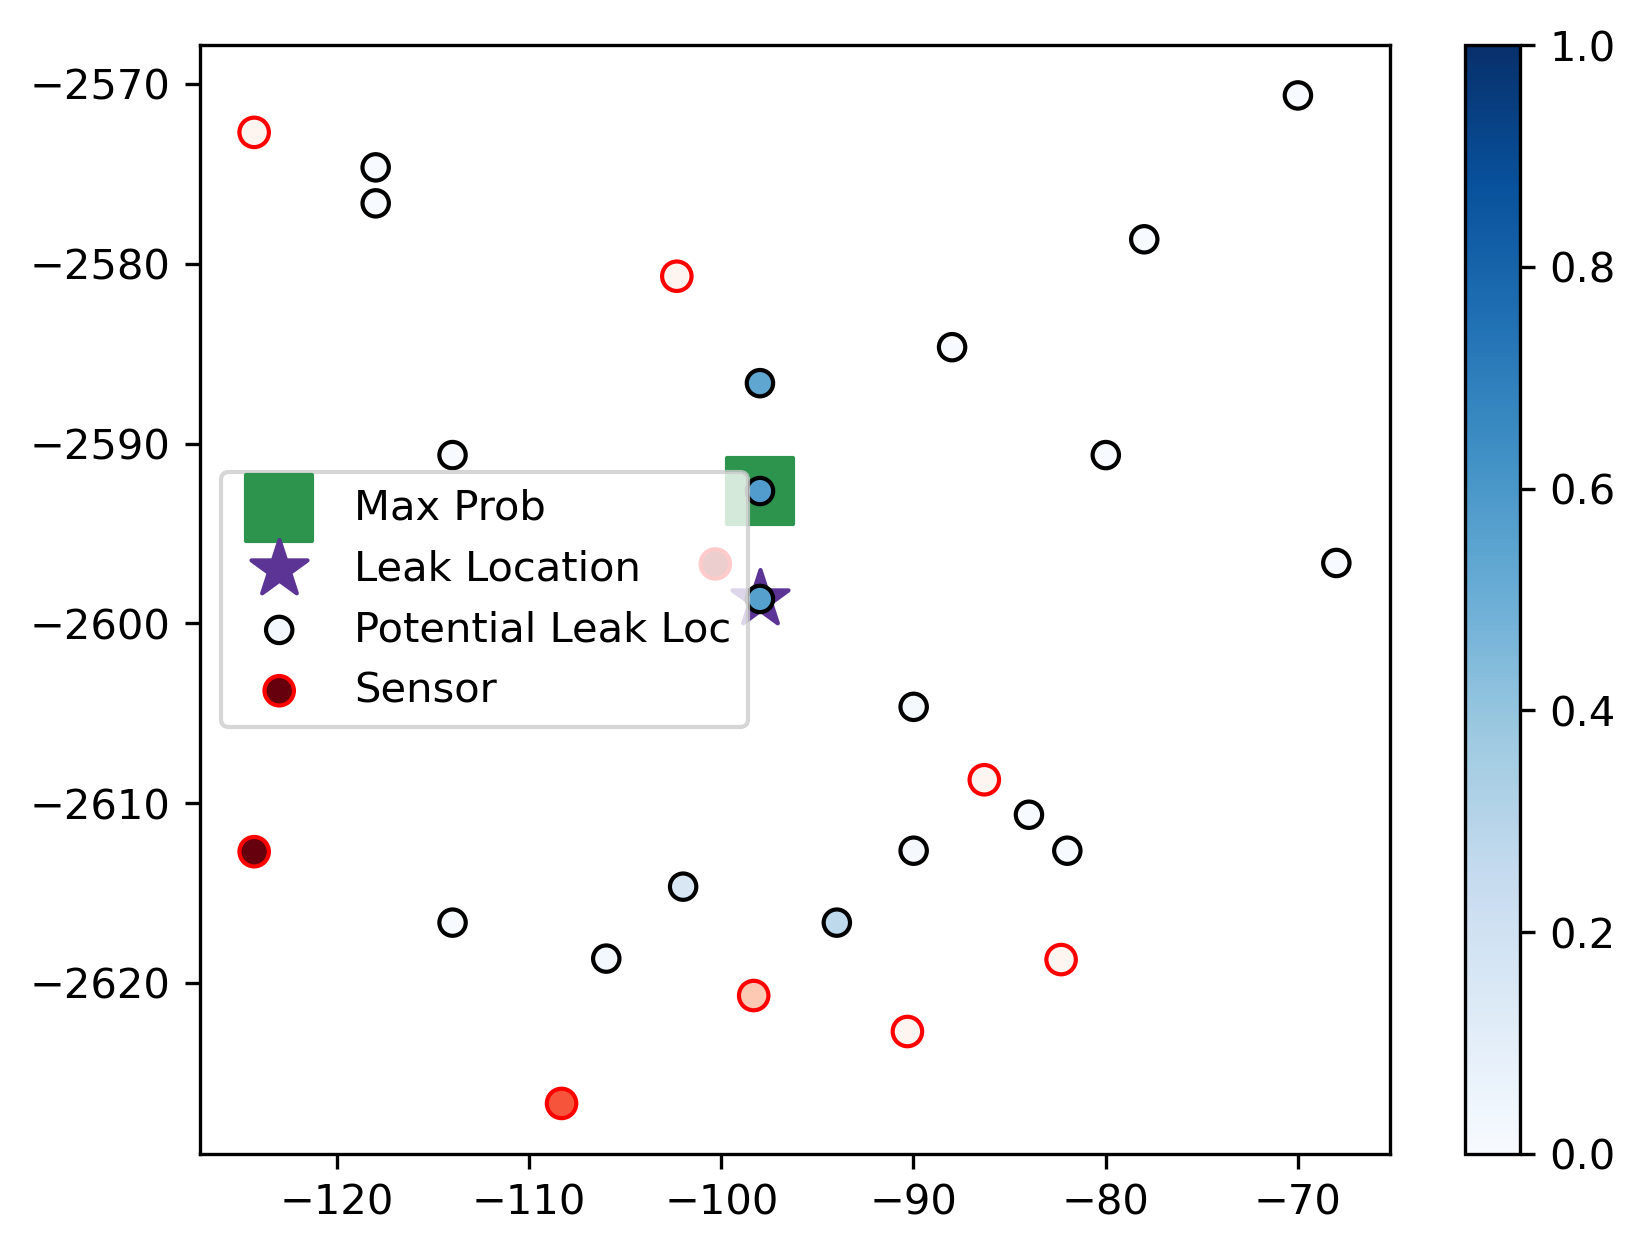

In [143]:
plt.figure(dpi=300)
idx = 0
mask = val_decoder[idx, :, 0, 0, 1].values > -1
r = val_decoder[idx, :, 0, 0, 0].values[mask]
az_sin = val_decoder[idx, :, 0, 1, 0].values[mask]
az_cos = val_decoder[idx, :, 0, 2, 0].values[mask]
x = r * az_cos
y = r * az_sin
t = targets[idx].argmax()
p_max = pred_ds["probabilities"].values[idx][mask].argmax()
plt.scatter(x[p_max], y[p_max], 250, 1, marker='s', vmin=0, vmax=1.4, cmap="Greens", label="Max Prob") 
plt.scatter(x[t], y[t], 200, 1, marker='*', vmin=0, vmax=1.2, cmap="Purples", label="Leak Location")

plt.scatter(x, y, 40, pred_ds["probabilities"].values[idx][mask], cmap="Blues", vmin=0, vmax=1, edgecolor='k', label="Potential Leak Loc")
plt.colorbar()
s_mask = val_encoder[idx, :, 0, 0, 1].values > -1
s_r = val_encoder[idx, :, 0, 0, 0].values[s_mask]
s_az_sin = val_encoder[idx, :, 0, 1, 0].values[s_mask]
s_az_cos = val_encoder[idx, :, 0, 2, 0].values[s_mask]
s_x = s_r * s_az_cos
s_y = s_r * s_az_sin
max_ch4 = val_encoder[idx, :, :, -1, 0].max(axis=-1)
plt.scatter(s_x, s_y, 50, np.log10(max_ch4[s_mask]), edgecolor='red', cmap="Reds", label="Sensor")
plt.legend(fontsize=10)
plt.savefig("transformer_test_example.png", dpi=300, bbox_inches="tight")

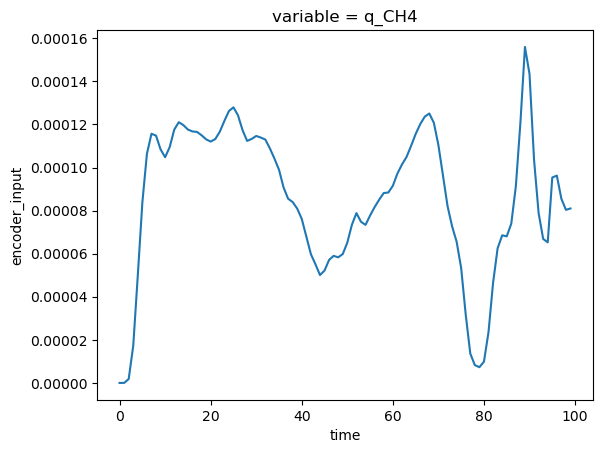

In [123]:
val_encoder[idx, 0, :, -1, 0].plot()

In [126]:
val_encoder[idx, :, :, -1, 0].max(axis=-1)

<xarray.DataArray 'encoder_input' (sensor: 10)>
dask.array<_nanmax_skip-aggregate, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    variable  <U12 'q_CH4'
Dimensions without coordinates: sensor

In [83]:
pred_ds["probabilities"].values[idx]

array([1.56143345e-02, 1.57438189e-01, 5.88174701e-01, 1.78029411e-04,
       1.75790906e-01, 1.22181863e-01, 5.70282509e-07, 5.70282509e-07,
       5.70282509e-07, 5.70282509e-07, 5.70282509e-07, 5.70282509e-07,
       5.70282509e-07, 5.70282509e-07, 5.70282509e-07, 5.70282509e-07,
       5.70282509e-07, 5.70282509e-07, 5.70282509e-07, 5.70282509e-07],
      dtype=float32)